In [8]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Dataset

In [9]:
df = pd.read_csv('data/univ-latencies/univ-latencies.txt')

In [10]:
df.head(2)

,acu-edu,acadiau-ca,adrian-edu,agnesscott-edu,aims-edu,uni-freiburg-de,alfred-edu,alvernia-edu,alverno-edu,american-edu,...,williams-edu,wsc-nodak-edu,winona-msus-edu,wpi-edu,wright-edu,yale-edu,yu-edu,yorku-ca,upenn-edu,ens-fr
0,396,381,488,506,333,1327,132,70,456,121,...,220,1898,434,125,304,94,460,347,532,429
1,271,261,488,504,276,1084,89,23,409,34,...,263,1032,294,74,269,252,98,265,233,293


In [11]:
mini = df.ix[:,:10]

In [12]:
mini.head(2)

,acu-edu,acadiau-ca,adrian-edu,agnesscott-edu,aims-edu,uni-freiburg-de,alfred-edu,alvernia-edu,alverno-edu,american-edu
0,396,381,488,506,333,1327,132,70,456,121
1,271,261,488,504,276,1084,89,23,409,34


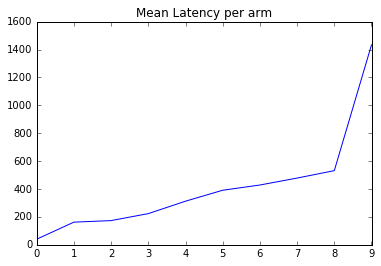

In [13]:
plt.title("Mean Latency per arm")
plt.plot(sorted(mini.mean()))

In [14]:
optimal = mini.min(axis=1).mean()
worst = mini.max(axis=1).mean()
random = np.mean(
    [ np.mean([np.random.choice(mini.ix[:, t]) for t in range(mini.shape[1])]) for _ in range(30) ]
)
print("optimal strategy (oracle) mean reward: %.2f" % optimal)
print("worst: %.2f" % worst)
print("random: %.2f" % random)
print("improvement ratio opt/rand: %dx" % (random/optimal))

optimal strategy (oracle) mean reward: 26.54
worst: 1933.03
random: 400.47
improvement ratio opt/rand: 15x


# Algorithms

In [41]:
class Bandit():
    def __init__(self, n_arms):
        self.n_arms = n_arms
    def pull(self) -> int:
        raise NotImplemented()
    def feedback(self, arm: int, reward):
        raise NotImplemented()    
        
class WeightedRandomBandit(Bandit):
    def __init__(self, n_arms):
        Bandit.__init__(self, n_arms)
        self.reward_sum_per_arm = np.zeros(n_arms)
        self.actions_per_arm = np.zeros(n_arms)        
    def pull(self) -> int:
        unpulled_arms = [_ for _ in range(self.n_arms) if self.actions_per_arm[_] < 1]
        if len(unpulled_arms):
            return np.random.choice(unpulled_arms)
        arms_weights = self.reward_sum_per_arm/self.actions_per_arm
        arms_weights = 1 / arms_weights
        arms_weights = arms_weights / np.sum(arms_weights)
        return np.random.choice(self.n_arms, p=arms_weights)
    def feedback(self, arm: int, reward):
        self.actions_per_arm[arm] += 1
        self.reward_sum_per_arm[arm] += 1

# Evaluation

In [120]:
exp.data.mean().min()

40.316678912564292

In [139]:
class Experiment():
    def __init__(self, dataframe: pd.DataFrame):
        self.data = dataframe
        self.actions = []
        self.regrets = []
        self.actions_per_arm = np.zeros(self.n_arms)
        self.reward_sum_per_arm = np.zeros(self.n_arms)
    @property
    def n_arms(self):
        return self.data.shape[1]
    def run(self, b: Bandit):
        for t in range(self.data.shape[0]):
            a = b.pull()
            r = self.data.ix[t, a]
            b.feedback(a, r)
            self.actions += [a]
            self.regrets += [r - self.data.ix[t,:].min()]
            self.actions_per_arm[a] += 1
            self.reward_sum_per_arm += 1
    
    @property
    def mean_regret(self):
        return np.mean(self.regrets)
    
    @property
    def total_regret(self):
        return np.sum(self.regrets)

    def regret_analysis(self):
        optimal = self.data.min(axis=1).mean()
        worst = self.data.max(axis=1).mean()
        random = np.mean(
            [ np.mean([np.random.choice(self.data.ix[:, t]) for t in range(self.data.shape[1])]) for _ in range(30) ]
        )
        return pd.DataFrame(data={
                'E[R]*': [optimal],
                'E[R]^rand': [random],
                'E[R]': [self.mean_regret],
                'E[R]/E[R]^rand': [np.round(self.mean_regret/random, decimals=2)],
                'E[R]/E[R]*': [np.round(self.mean_regret/optimal, decimals=2)]
            })
    
    def arms_analysis(self):
        true_means = self.data.mean()
        comp = pd.DataFrame(pd.concat([
                    true_means, 
                    pd.Series(self.actions_per_arm, index=true_means.index),
                    pd.Series(self.reward_sum_per_arm/self.actions_per_arm, index=true_means.index),
                ], axis=1).values, columns=['true_mean_reward', 'pull_count', 'observed_mean_reward'])
        return comp.sort_values(by='true_mean_reward')
    
    def cumulated_regret_analysis(self):
        rng = pd.date_range('1/1/2011', periods=len(self.regrets), freq='600s')
        mean_delta = self.data.mean().max() - self.data.mean().min()
        print(mean_delta)
        ts = pd.DataFrame(data={
                #'cumulated_regret': np.cumsum(self.regrets), 
                'mean_cumulated_regret': np.cumsum(self.regrets) / np.cumsum(np.ones(len(self.regrets))),
                #'full monitoring regret bound': np.ones(len(self.regrets))* (1 / mean_delta)
            }, index=rng)
        return ts

         E[R]      E[R]*  E[R]/E[R]*  E[R]/E[R]^rand  E[R]^rand
0  408.681852  26.537105        15.4            1.05     390.48
   true_mean_reward  pull_count  observed_mean_reward
7         40.316679         145              9.386207
9        162.451874         149              9.134228
6        173.508450         149              9.134228
1        223.562821         139              9.791367
4        312.650257         124             10.975806
0        391.088170         121             11.247934
8        428.579721         134             10.156716
3        478.344600         136             10.007353
2        531.591477         136             10.007353
5       1433.167524         128             10.632812
1392.85084497


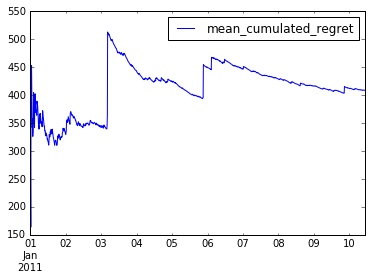

In [140]:
exp = Experiment(mini)
b = WeightedRandomBandit(exp.n_arms)
exp.run(b)
print(exp.regret_analysis())
print(exp.arms_analysis())
exp.cumulated_regret_analysis().plot()